In [1]:
import qiskit
qiskit.__version__

'0.24.0'

# Improved QASM2 Parser and Exporter

For Qiskit Terra 0.24.0 the QASM 2 exporter was refactored to fix a large number of bugs, including 

Alongside this a new QASM2 parser was introduced that was written primarily in Rust that offers significant performance improvements along with being more configurable and type safe.

In [2]:
from qiskit import qasm2 
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.random import random_circuit

qc = random_circuit(100, 100)
qasm_string = qc.qasm()

In [3]:
%timeit -n1 qasm2.loads(qasm_string, include_path=qasm2.LEGACY_INCLUDE_PATH, custom_instructions=qasm2.LEGACY_CUSTOM_INSTRUCTIONS, custom_classical=qasm2.LEGACY_CUSTOM_CLASSICAL, strict=False)

45.9 ms ± 2.05 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [4]:
%timeit -n1 QuantumCircuit.from_qasm_str(qasm_string)

617 ms ± 4.21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Transpiler Support for Disjoint/Multi-chip Devices

Support for devices like "Heron" from IBM hardware roadmap with discrete QPUs that have shared real-time classical communication


In [5]:
import numpy as np
import rustworkx as rx

from qiskit import transpile
from qiskit.providers import BackendV2, Options
from qiskit.transpiler import Target, InstructionProperties
from qiskit.circuit.library import XGate, SXGate, RZGate, CZGate
from qiskit.circuit import Measure, Delay, Parameter

In [6]:
class FakeMultiChip(BackendV2):
    """Fake multi chip backend."""

    def __init__(self, degree=3):
        super().__init__(name='multi_chip')
        graph = rx.generators.directed_heavy_hex_graph(degree, bidirectional=False)
        num_qubits = len(graph) * 3
        rng = np.random.default_rng(seed=12345678942)
        rz_props = {}
        x_props = {}
        sx_props = {}
        measure_props = {}
        delay_props = {}
        self._target = Target("Fake multi-chip backend", num_qubits=num_qubits)
        for i in range(num_qubits):
            qarg = (i,)
            rz_props[qarg] = InstructionProperties(error=0.0, duration=0.0)
            x_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-6, 1e-4), duration=rng.uniform(1e-8, 9e-7)
            )
            sx_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-6, 1e-4), duration=rng.uniform(1e-8, 9e-7)
            )
            measure_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-3, 1e-1), duration=rng.uniform(1e-8, 9e-7)
            )
            delay_props[qarg] = None
        self._target.add_instruction(XGate(), x_props)
        self._target.add_instruction(SXGate(), sx_props)
        self._target.add_instruction(RZGate(Parameter("theta")), rz_props)
        self._target.add_instruction(Measure(), measure_props)
        self._target.add_instruction(Delay(Parameter("t")), delay_props)
        cz_props = {}
        for i in range(3):
            for root_edge in graph.edge_list():
                offset = i * len(graph)
                edge = (root_edge[0] + offset, root_edge[1] + offset)
                cz_props[edge] = InstructionProperties(
                    error=rng.uniform(1e-5, 5e-3), duration=rng.uniform(1e-8, 9e-7)
                )
        self._target.add_instruction(CZGate(), cz_props)

    @property
    def target(self):
        return self._target
    
    @property
    def max_circuits(self):
        return None

    @classmethod
    def _default_options(cls):
        return Options(shots=1024)

    def run(self, circuit, **kwargs):
        raise NotImplementedError    

57


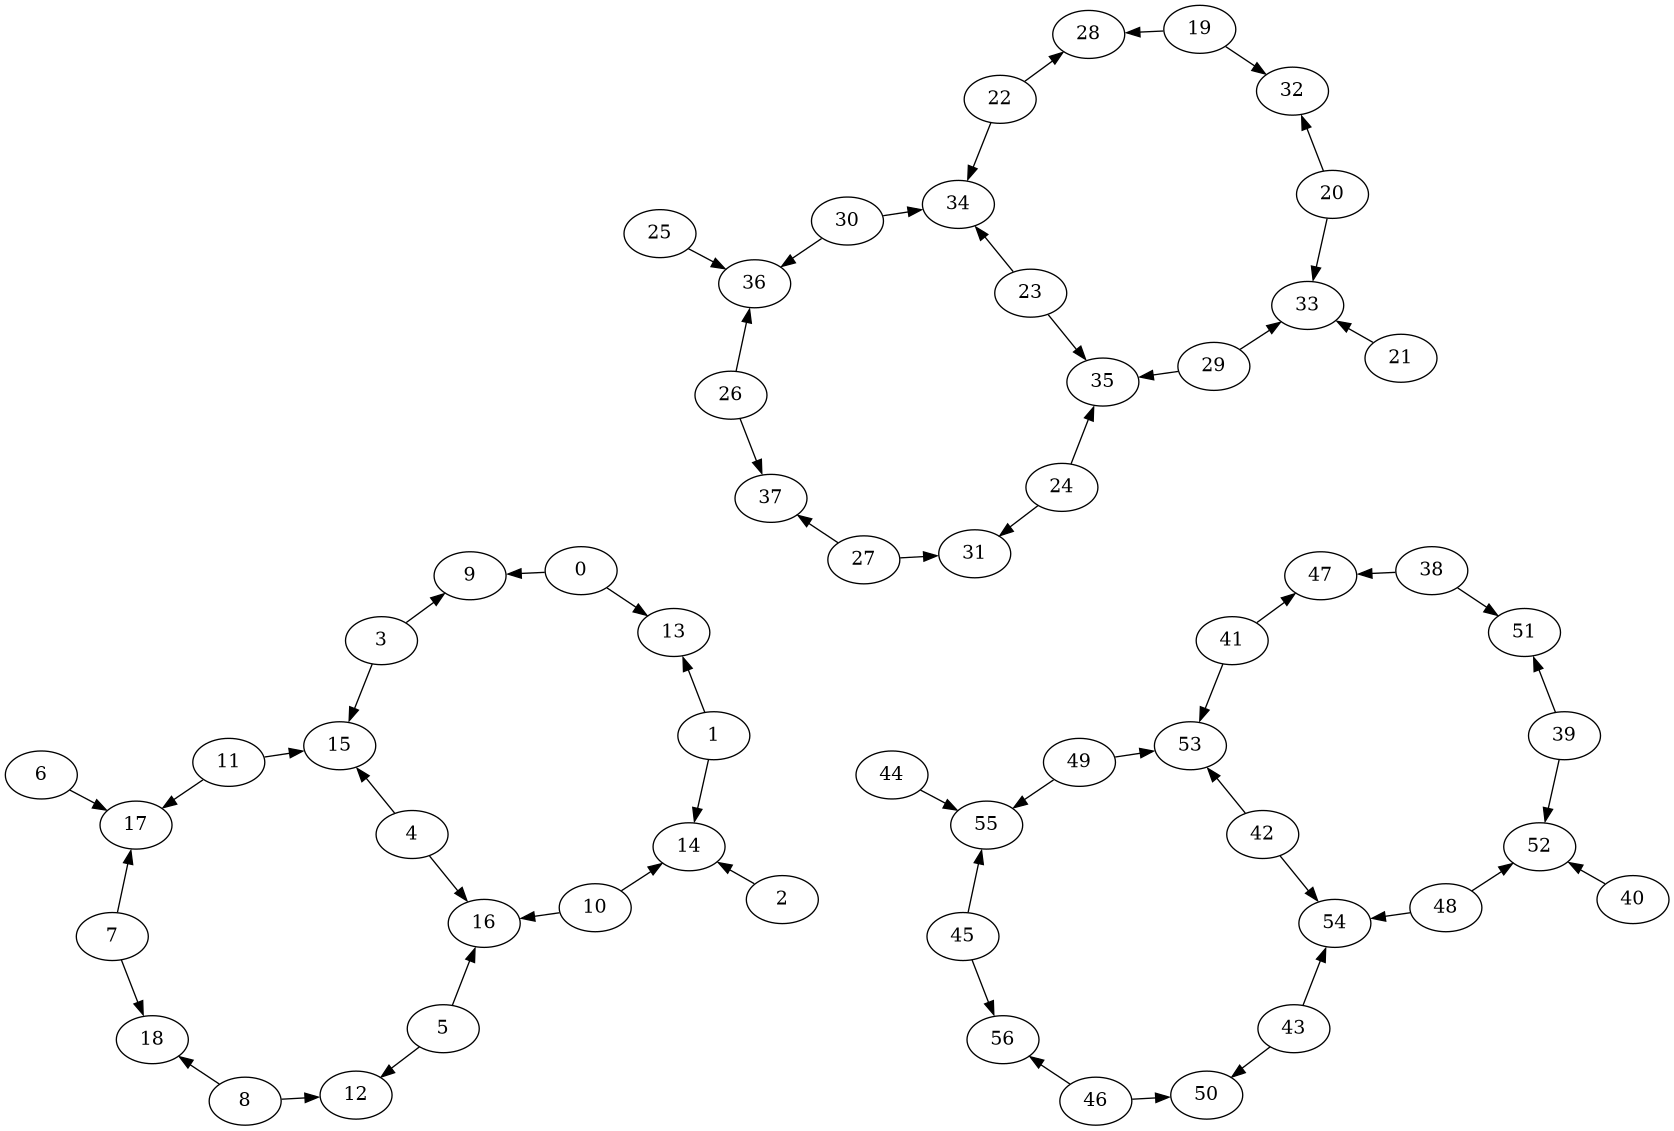

In [7]:
backend = FakeMultiChip()
print(backend.num_qubits)
backend.coupling_map.draw()

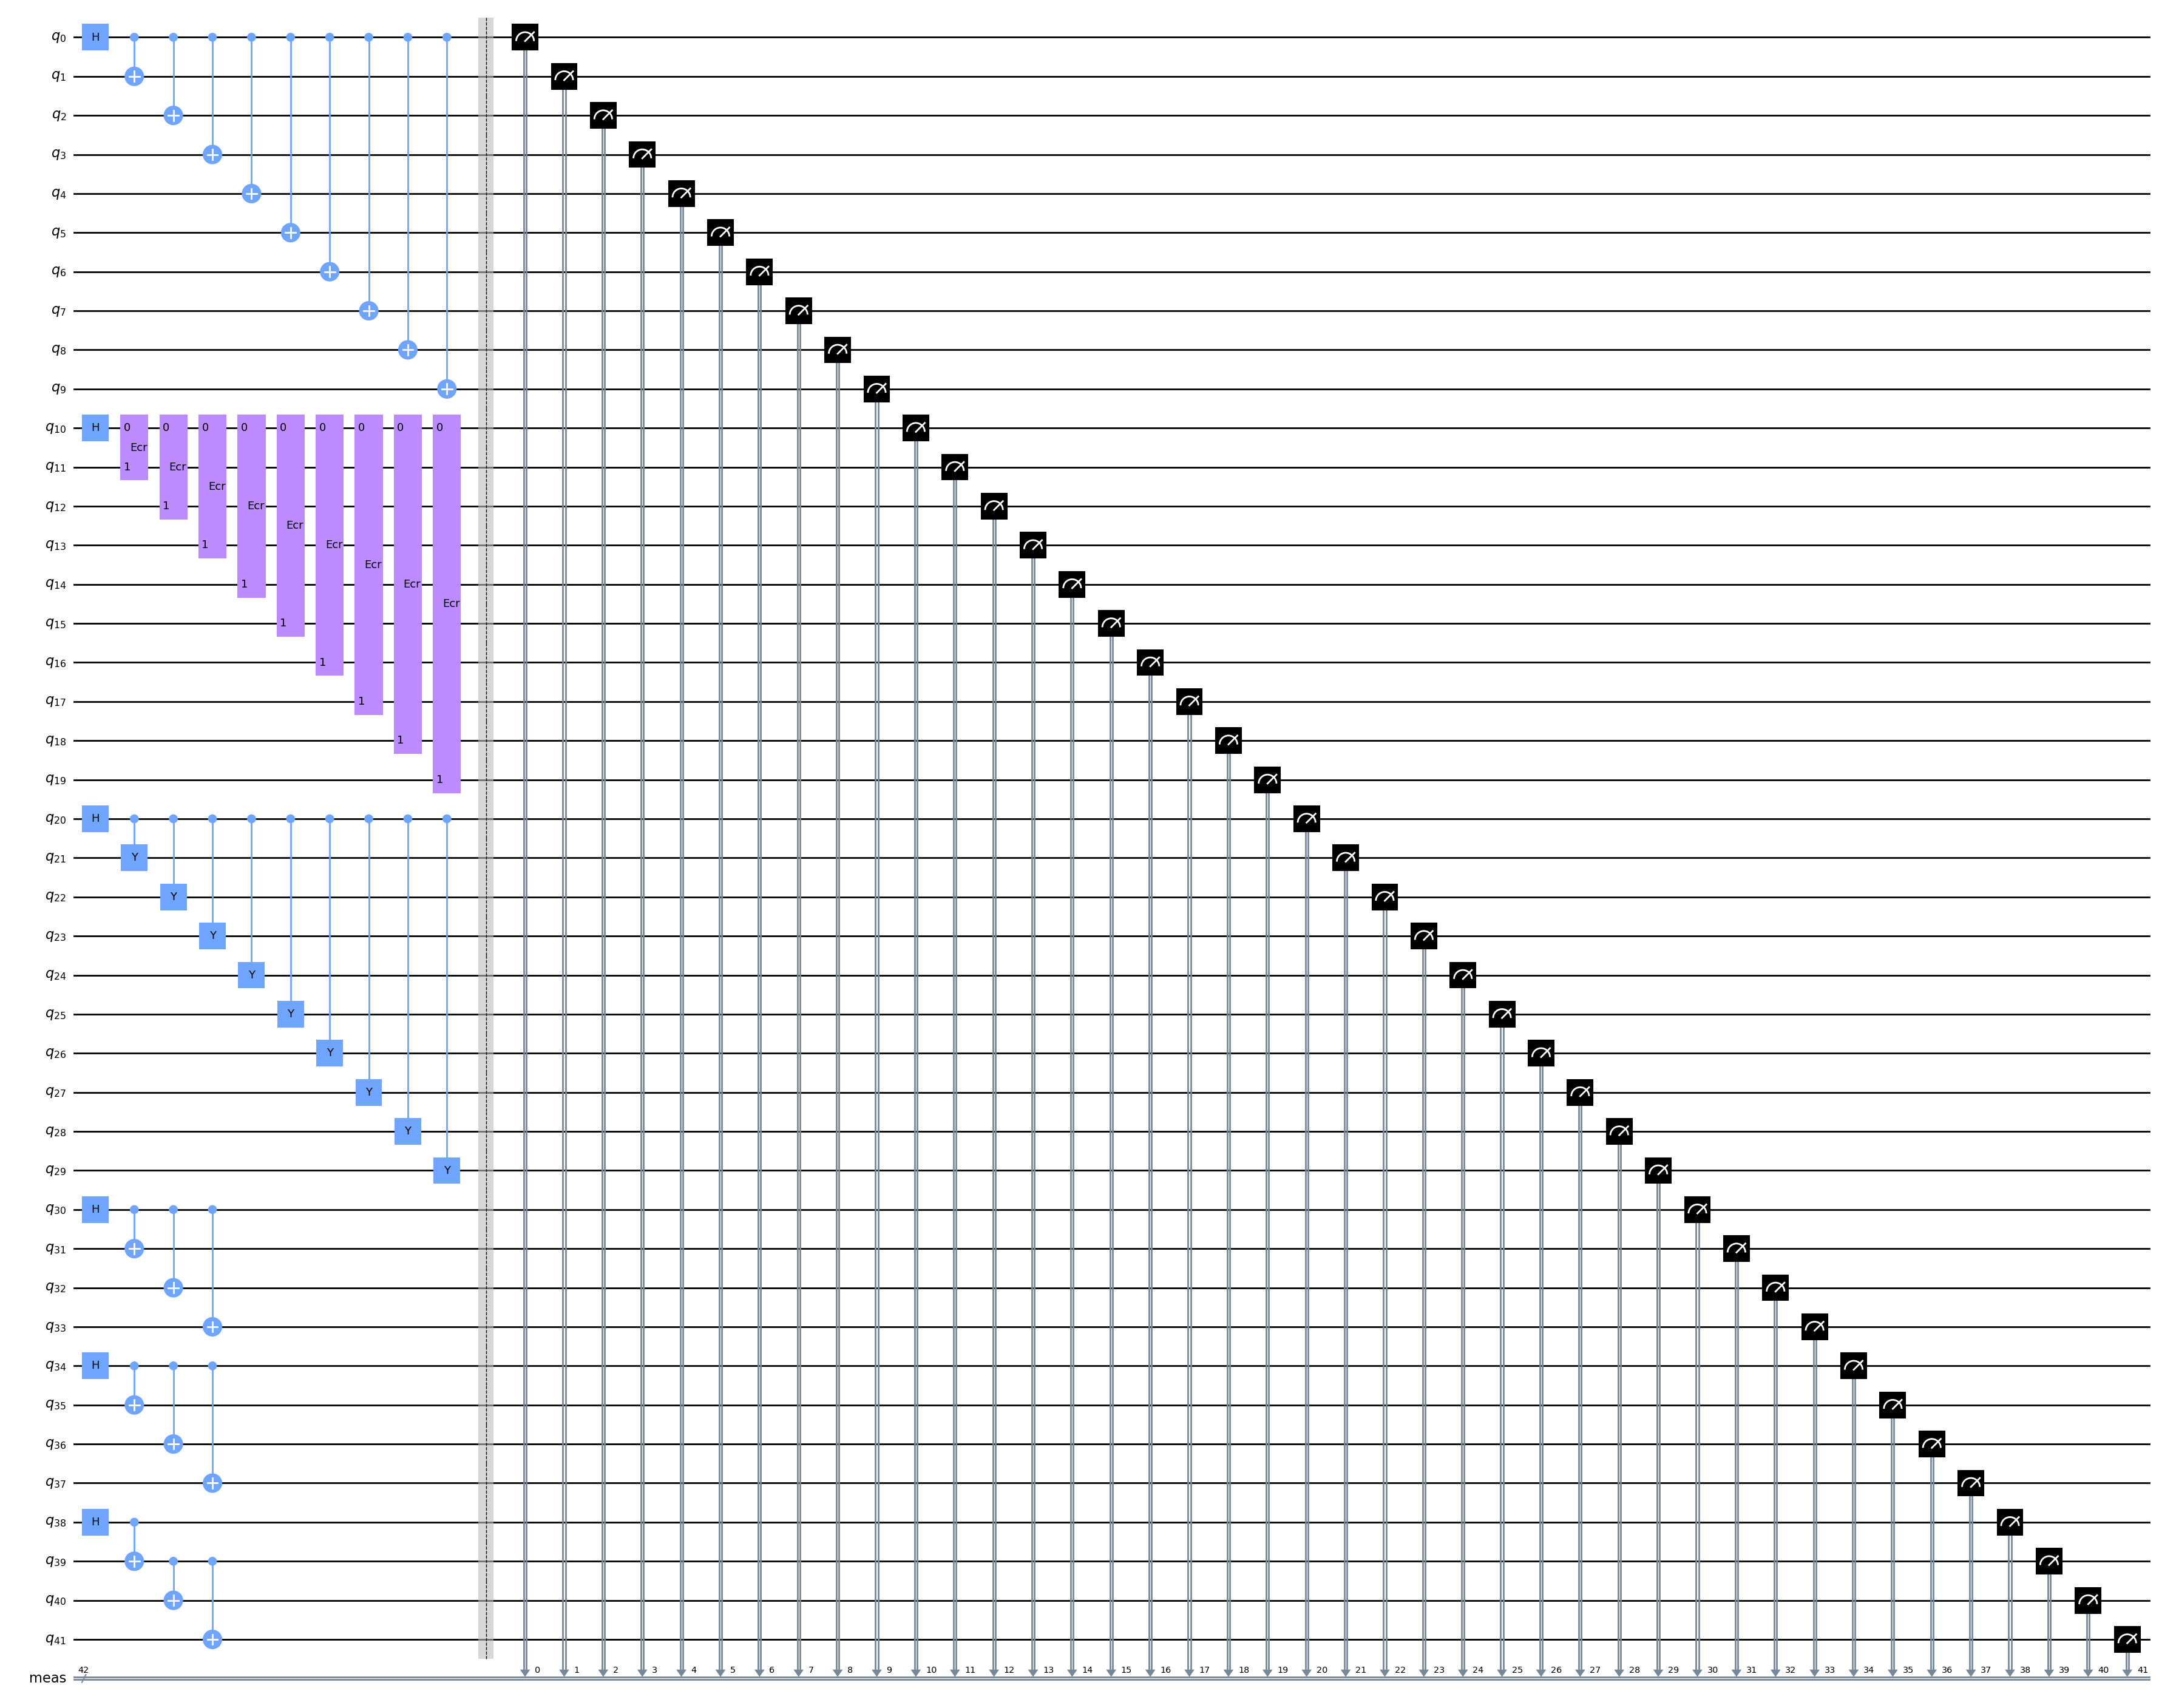

In [8]:
qc = QuantumCircuit(42)
qc.h(0)
qc.h(10)
qc.h(20)
qc.cx(0, 1)
qc.cx(0, 2)
qc.cx(0, 3)
qc.cx(0, 4)
qc.cx(0, 5)
qc.cx(0, 6)
qc.cx(0, 7)
qc.cx(0, 8)
qc.cx(0, 9)
qc.ecr(10, 11)
qc.ecr(10, 12)
qc.ecr(10, 13)
qc.ecr(10, 14)
qc.ecr(10, 15)
qc.ecr(10, 16)
qc.ecr(10, 17)
qc.ecr(10, 18)
qc.ecr(10, 19)
qc.cy(20, 21)
qc.cy(20, 22)
qc.cy(20, 23)
qc.cy(20, 24)
qc.cy(20, 25)
qc.cy(20, 26)
qc.cy(20, 27)
qc.cy(20, 28)
qc.cy(20, 29)
qc.h(30)
qc.cx(30, 31)
qc.cx(30, 32)
qc.cx(30, 33)
qc.h(34)
qc.cx(34, 35)
qc.cx(34, 36)
qc.cx(34, 37)
qc.h(38)
qc.cx(38, 39)
qc.cx(39, 40)
qc.cx(39, 41)
qc.measure_all()
qc.draw('mpl', fold=-1)

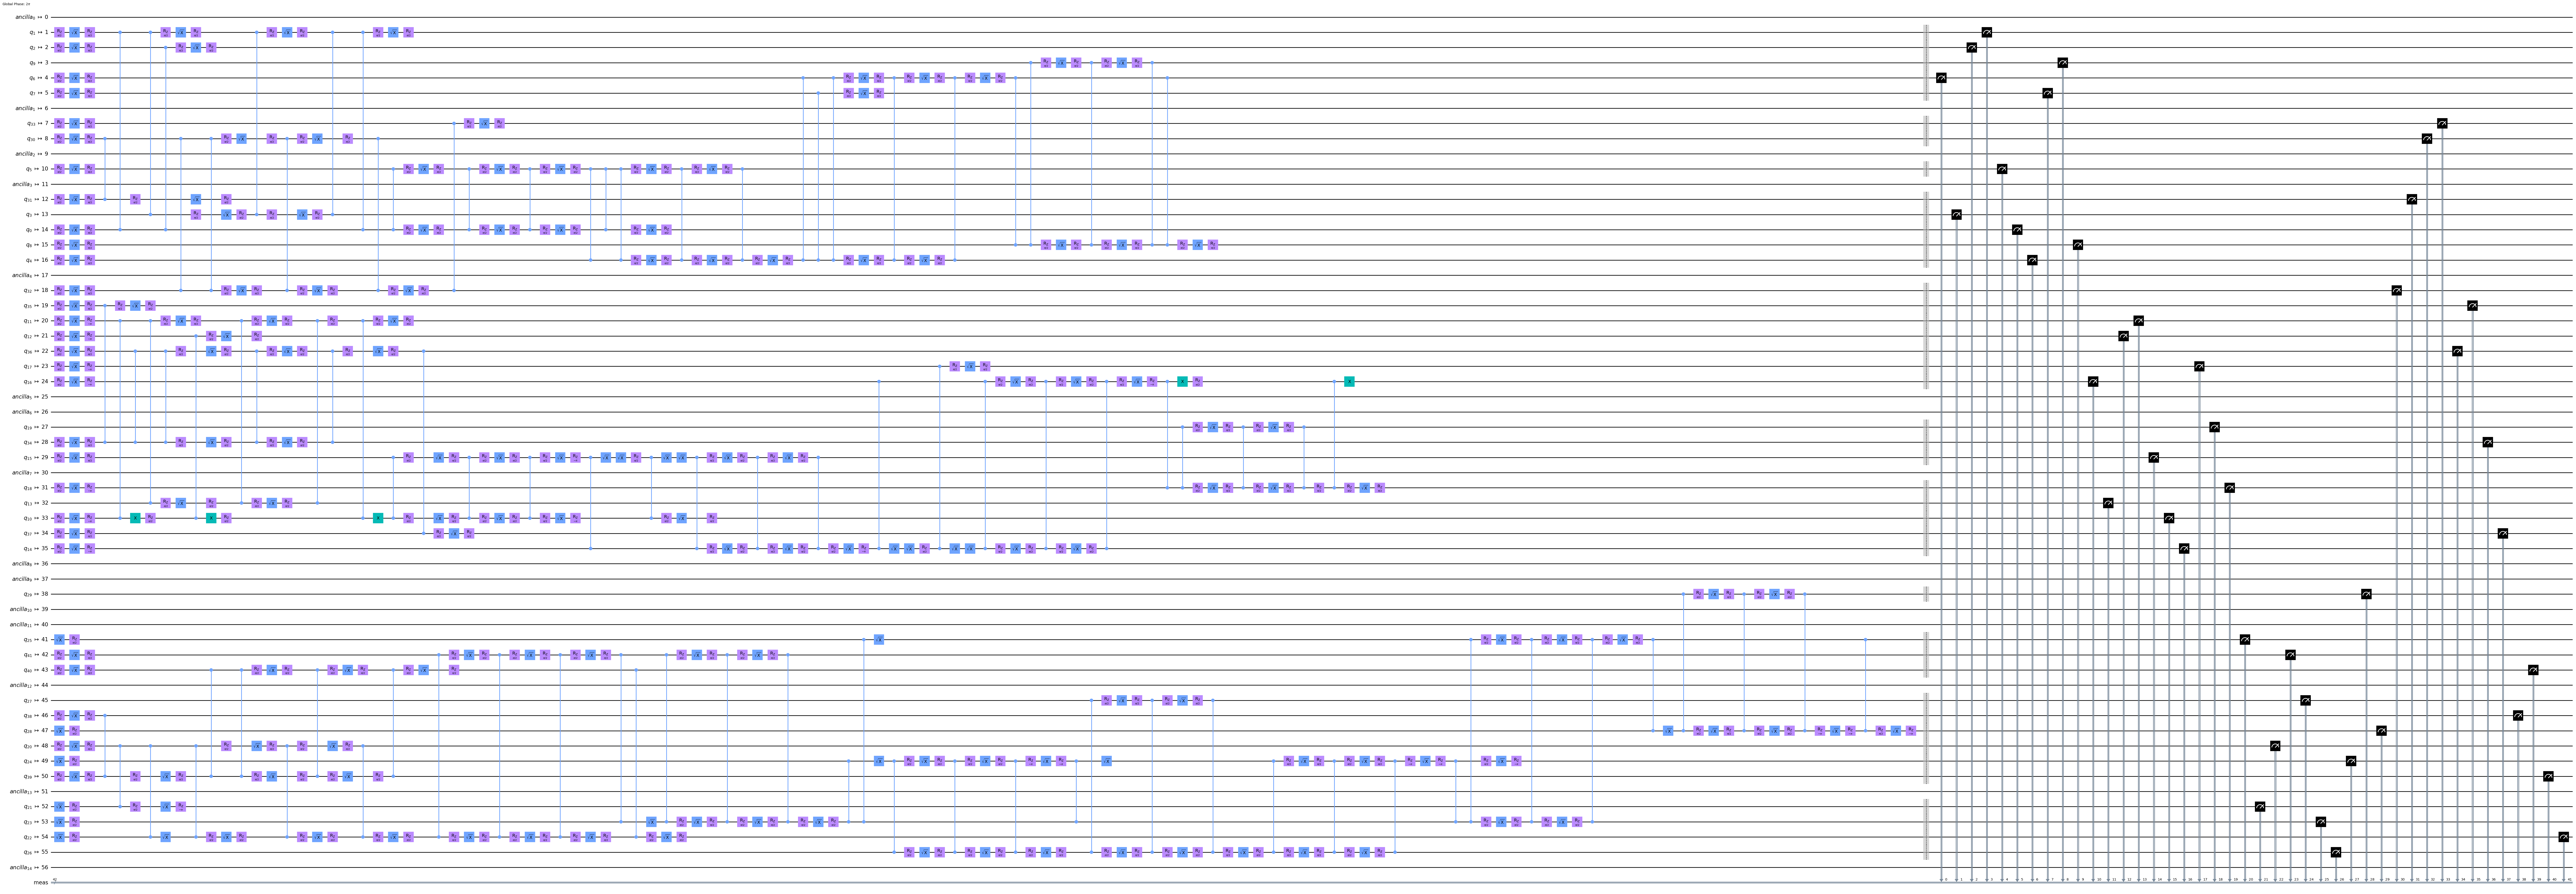

In [9]:
res = transpile(qc, backend, seed_transpiler=420)
res.draw('mpl', fold=-1)

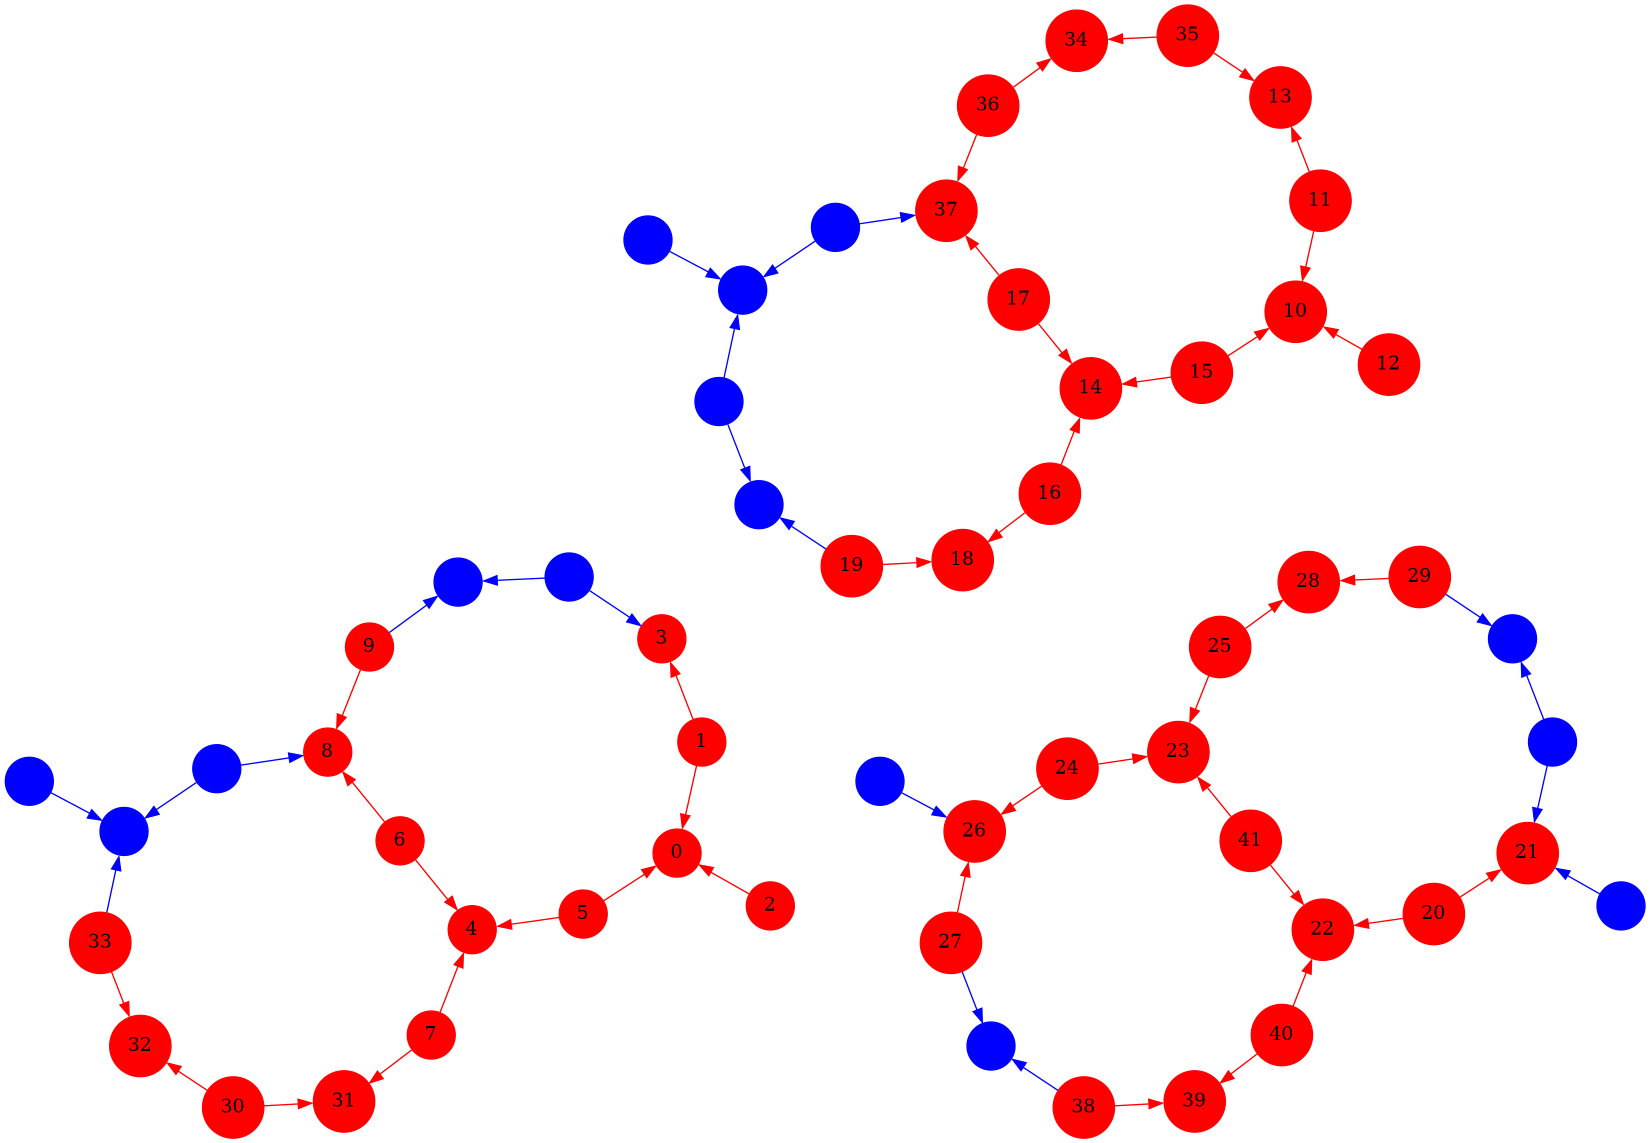

In [10]:
from rustworkx.visualization import graphviz_draw

graph = backend.target.build_coupling_map("cz").graph
for node in graph.node_indices():
    graph[node] = node
    
for edge, triple in graph.edge_index_map().items():
    graph.update_edge_by_index(edge, (triple[0], triple[1]))

physical_bits = {k: v for k, v in res.layout.initial_layout.get_physical_bits().items() if "ancilla" not in v._register.name}

qubit_indices = {bit: index for index, bit in enumerate(qc.qubits)}
def color_node(node):
    if node in physical_bits:
        out_dict = {
            "label": str(res.layout.input_qubit_mapping[physical_bits[node]]),
            "color": "red",
            "fillcolor": "red",
            "style": "filled",
            "shape": "circle",
        }
    else:
        out_dict = {
            "label": "",
            "color": "blue",
            "fillcolor": "blue",
            "style": "filled",
            "shape": "circle",
        }
    return out_dict

def color_edge(edge):
    if all(x in physical_bits for x in edge):
        out_dict = {
            "color": "red",
            "fillcolor": "red",
        }
    else:
        out_dict = {
            "color": "blue",
            "fillcolor": "blue",
        }
    return out_dict
        
graphviz_draw(graph, method="neato", node_attr_fn=color_node, edge_attr_fn=color_edge)


In [11]:
from qiskit.transpiler import TranspilerError

qc = QuantumCircuit(42)
qc.h(0)
for i in range(41):
    qc.cx(0, i + 1)
qc.measure_all()
try:
    transpile(qc, backend)
except TranspilerError as e:
    print(e)

'A connected component of the DAGCircuit is too large for any of the connected components in the coupling map.'


# Deprecation of `QuantumInstance`, `qiskit.opflow`, and their usage in `qiskit.algorithms`

In [12]:
from qiskit import opflow

/tmp/ipykernel_382932/326177561.py:1: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit import opflow


In [13]:
from qiskit.utils import QuantumInstance

QuantumInstance(backend)

/tmp/ipykernel_382932/327717645.py:3: DeprecationWarning: The class ``qiskit.utils.quantum_instance.QuantumInstance`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/qi_migration.
  QuantumInstance(backend)


In [14]:
from qiskit.algorithms.minimum_eigen_solvers import VQE
VQE()

/tmp/ipykernel_382932/1544760973.py:2: DeprecationWarning: The class ``qiskit.algorithms.minimum_eigen_solvers.vqe.VQE`` is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. Instead, use the class ``qiskit.algorithms.minimum_eigensolvers.VQE``. See https://qisk.it/algo_migration for a migration guide.
  VQE()


# New control flow operation switch:

In [15]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

In [16]:
qreg = QuantumRegister(2)
creg = ClassicalRegister(2)
qc = QuantumCircuit(qreg, creg)
qc.h([0, 1])
qc.measure([0, 1], [0, 1])
with qc.switch(creg) as case:
    with case(0):  # if the register is '00'
        qc.z(0)
    with case(1, 2):  # if the register is '01' or '10'
        qc.cx(0, 1)
    with case(case.DEFAULT):  # the default case
        qc.h(0)

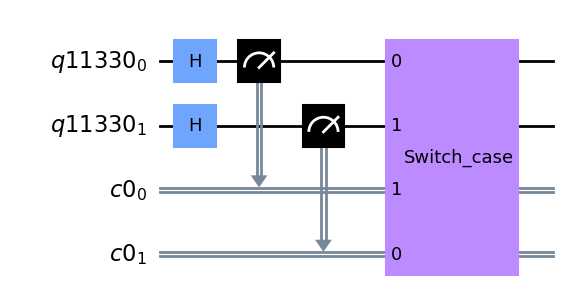

In [17]:
qc.draw('mpl')

In [18]:
from qiskit.circuit import SwitchCaseOp
backend.target.add_instruction(SwitchCaseOp, name='switch_case')

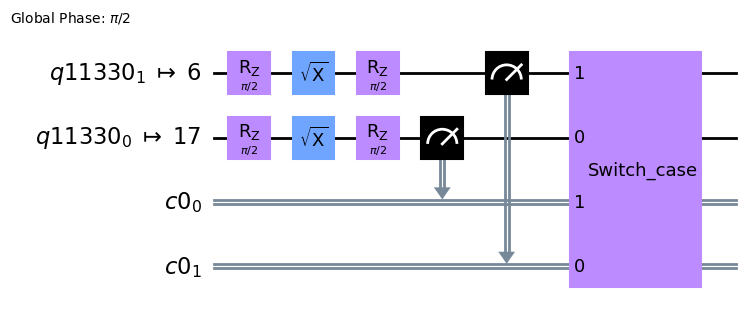

In [19]:
tqc = transpile(qc, backend)
tqc.draw('mpl', idle_wires=False)

In [20]:
from qiskit.qasm3 import dumps
from qiskit.qasm3 import ExperimentalFeatures
print(dumps(qc, experimental=ExperimentalFeatures.SWITCH_CASE_V1))

OPENQASM 3;
include "stdgates.inc";
bit[2] c0;
int switch_dummy;
qubit[2] _all_qubits;
let q11330 = _all_qubits[0:1];
h q11330[0];
h q11330[1];
c0[0] = measure q11330[0];
c0[1] = measure q11330[1];
switch_dummy = c0;
switch (switch_dummy) {
  case 0: {
    z q11330[0];
  }
  break;
  case 1:
  case 2: {
    cx q11330[0], q11330[1];
  }
  break;
  default: {
    h q11330[0];
  }
  break;
}



In [21]:
print(dumps(tqc, experimental=ExperimentalFeatures.SWITCH_CASE_V1))

OPENQASM 3;
include "stdgates.inc";
bit[2] c0;
int switch_dummy;
rz(pi/2) $6;
sx $6;
rz(pi/2) $6;
rz(pi/2) $17;
sx $17;
rz(pi/2) $17;
c0[0] = measure $17;
c0[1] = measure $6;
switch_dummy = c0;
switch (switch_dummy) {
  case 0: {
    rz(-pi) $17;
  }
  break;
  case 1:
  case 2: {
    rz(pi/2) $6;
    sx $6;
    rz(pi/2) $6;
    cz $6, $17;
    rz(pi/2) $6;
    sx $6;
    rz(pi/2) $6;
  }
  break;
  default: {
    rz(pi/2) $17;
    sx $17;
    rz(pi/2) $17;
  }
  break;
}



In [22]:
import io
from qiskit.qpy import dump, load

with io.BytesIO() as fd:
    dump(tqc, fd)
    fd.seek(0)
    loaded_tqc = load(fd)[0]
print(dumps(loaded_tqc, experimental=ExperimentalFeatures.SWITCH_CASE_V1))

OPENQASM 3;
include "stdgates.inc";
bit[2] c0;
int switch_dummy;
qubit[57] _all_qubits;
let q = _all_qubits[0:56];
rz(pi/2) q[6];
sx q[6];
rz(pi/2) q[6];
rz(pi/2) q[17];
sx q[17];
rz(pi/2) q[17];
c0[0] = measure q[17];
c0[1] = measure q[6];
switch_dummy = c0;
switch (switch_dummy) {
  case 0: {
    rz(-pi) q[17];
  }
  break;
  case 1:
  case 2: {
    rz(pi/2) q[6];
    sx q[6];
    rz(pi/2) q[6];
    cz q[6], q[17];
    rz(pi/2) q[6];
    sx q[6];
    rz(pi/2) q[6];
  }
  break;
  default: {
    rz(pi/2) q[17];
    sx q[17];
    rz(pi/2) q[17];
  }
  break;
}



# Transpile() performance improvements

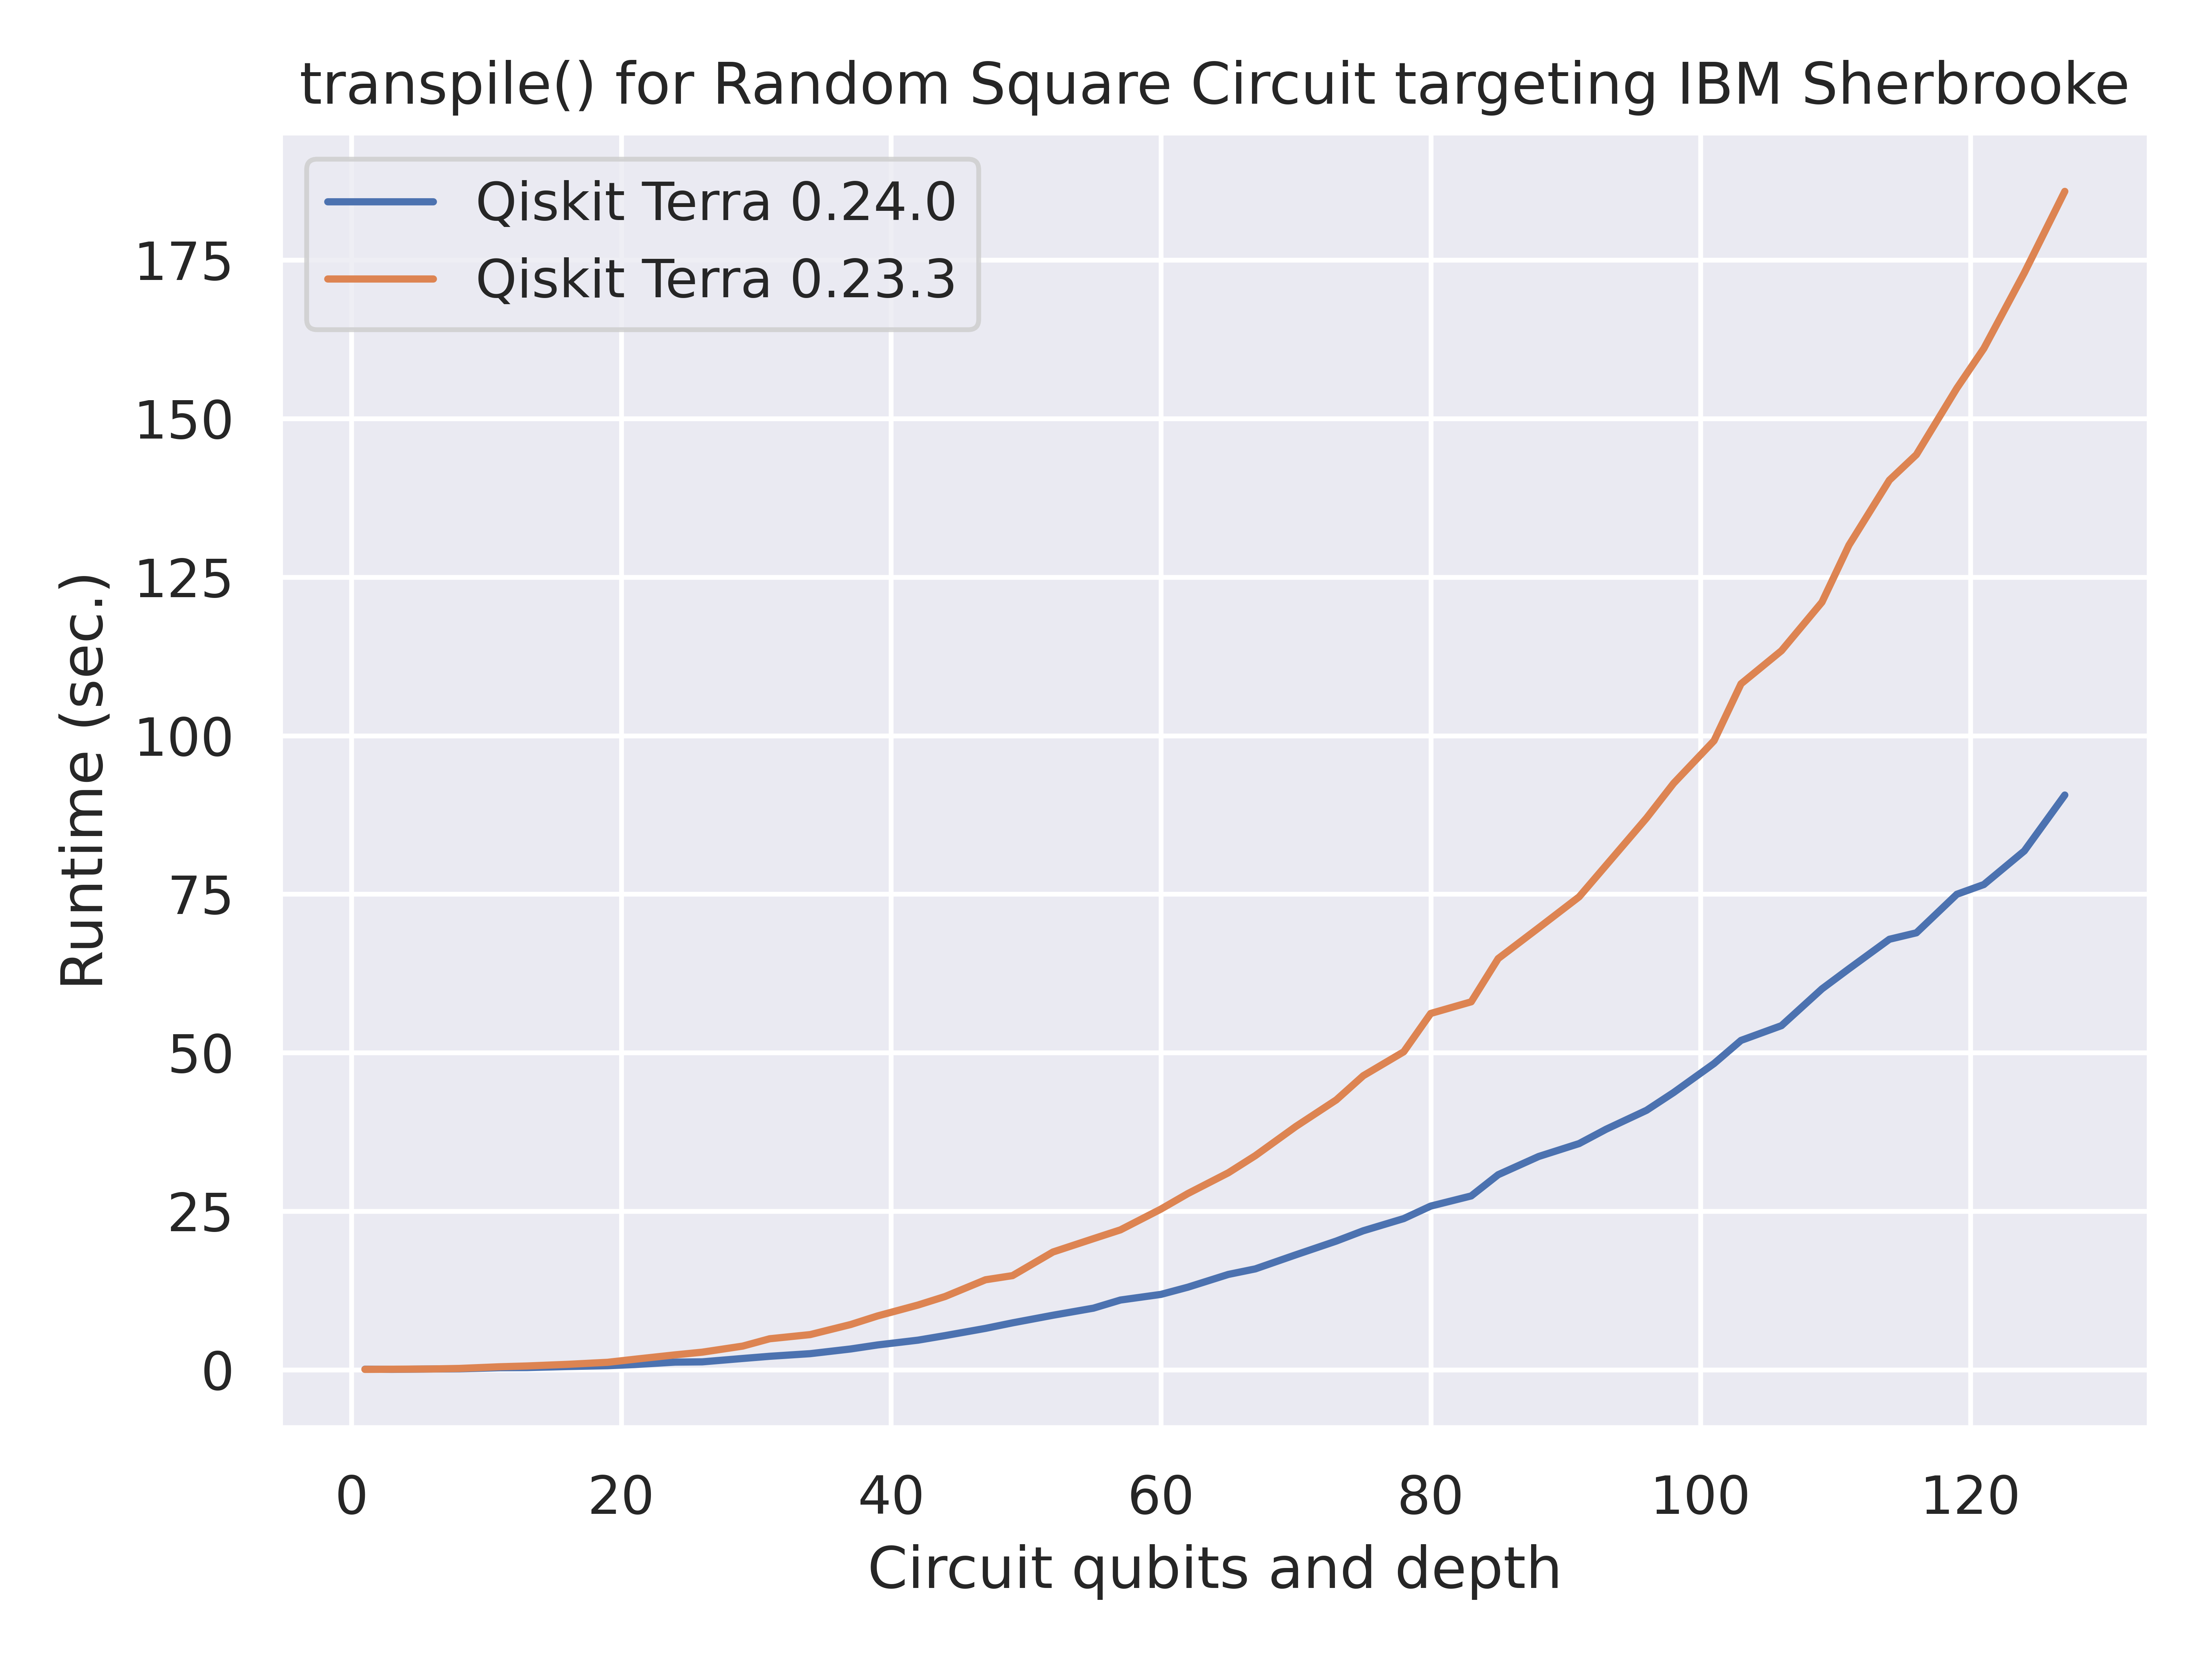

In [ ]:
import time

import numpy as np

from qiskit.circuit.random import random_circuit
from qiskit import transpile
from qiskit.providers.fake_provider import FakeSherbrooke
from qiskit.circuit.library import IGate

backend = FakeSherbrooke()
backend.target.add_instruction(IGate(), {(i,): None for i in range(backend.num_qubits)})

for i in np.linspace(1, backend.num_qubits, dtype=int):
    qc = random_circuit(i, i, measure=True, seed=42023)
    start = time.perf_counter()
    tqc = transpile(qc, backend)
    stop = time.perf_counter()
    print(f"{i}, {stop - start}")